In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from scipy.stats import pearsonr as corr

device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cpu'

In [3]:
# Initialize dictionary and input
n, m = 100, 10000  # dictionary size and input size
torch.manual_seed(42)
D = torch.randn(n, m)  # Random dictionary matrix
D /= torch.linalg.norm(D, dim=0, keepdim=True)
a0 = torch.tensor(expon(loc=0, scale=.1).rvs(m, random_state=42), dtype=torch.float32)
x = D @ a0
x.shape, D.shape, a0.shape

(torch.Size([100]), torch.Size([100, 10000]), torch.Size([10000]))

In [4]:
class LCA:
    def __init__(self, D, lr=None, lambd=0.1, max_iter=100, fac=0.5,
                 tol=1e-6, verbose=False):
        self.n, self.m = D.shape
        self.D = D  # Dictionary matrix (n, m)
        # lr: initial learning rate
        if type(lr) == type(None):
            self.lr = 1 / m  # this seemed to work pretty well
        else:
            self.lr = lr
        self.lambd = lambd  # Sparsity parameter
        self.max_iter = max_iter  # Max iterations
        assert (0 < fac) and (fac <= 1)
        self.facs = [fac, 1 / fac]  # Adaptation rate of lr
        self.tol = tol # convergence threshold
        self.verbose = verbose

    @staticmethod
    def reconstruction_error(x, x_):
        return torch.mean((x - x_) ** 2)

    @staticmethod
    def sparsity_penalty(a):
        return torch.mean(torch.abs(a))

    def inference(self, x):
        u = torch.zeros(m)
        a = torch.relu(u)
        lr = self.lr
        best_loss = np.inf
        rec = self.D @ a
        re = self.reconstruction_error(x, rec)
        l1 = self.sparsity_penalty(a)
        loss = re + self.lambd * l1
        for i in range(self.max_iter):
            if self.verbose:
                print('i', i, 're', re, 'l1', l1, 'lr', lr)
            if best_loss - loss < self.tol:
                if self.verbose:
                    print('converged at', i)
                break
            else:
                best_loss = loss
            # usually in LCA, one would precompute the recurrence matrix:
            # G = D.T @ D
            # However, because D is really tall, this would be low rank
            # So it is more compute efficient to do it sequentially like below:
            du = self.D.T @ (rec - x) + self.lambd
            # Below we will check whether to in- or decrease the learning rate
            # requires two checks but converges much faster.
            losses, u_news, a_news, res, l1s, recs = [], [], [], [], [], []
            for fac in self.facs:
                u_news.append(u - du * lr * fac)
                a_news.append(torch.relu(u_news[-1]))
                recs.append(self.D @ a_news[-1])
                res.append(self.reconstruction_error(x, recs[-1]))
                l1s.append(self.sparsity_penalty(a_news[-1]))
                losses.append(res[-1] + self.lambd * l1s[-1])
            ind = np.argmin(losses)
            u = u_news[ind]
            a = a_news[ind]
            rec = recs[ind]
            re = res[ind]
            l1 = l1s[ind]
            loss = losses[ind]
            lr *= self.facs[ind]
        return a

In [5]:
lca = LCA(D, fac=.5, verbose=True)
a = lca.inference(x)
a.shape

i 0 re tensor(2.0933) l1 tensor(0.) lr 0.0001
i 1 re tensor(2.0486) l1 tensor(0.0001) lr 0.0002
i 2 re tensor(1.9616) l1 tensor(0.0003) lr 0.0004
i 3 re tensor(1.7971) l1 tensor(0.0008) lr 0.0008
i 4 re tensor(1.5035) l1 tensor(0.0016) lr 0.0016
i 5 re tensor(1.0384) l1 tensor(0.0032) lr 0.0032
i 6 re tensor(0.4662) l1 tensor(0.0057) lr 0.0064
i 7 re tensor(0.0693) l1 tensor(0.0088) lr 0.0128
i 8 re tensor(0.0009) l1 tensor(0.0103) lr 0.0256
i 9 re tensor(0.0038) l1 tensor(0.0098) lr 0.0128
converged at 9


torch.Size([10000])

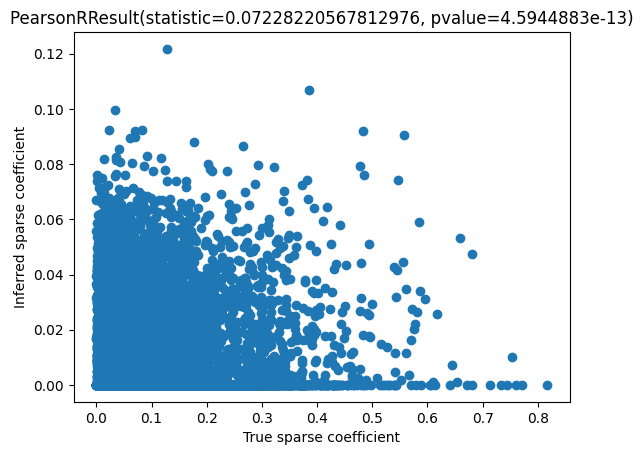

In [6]:
plt.scatter(a0, a)
plt.xlabel('True sparse coefficient')
plt.ylabel('Inferred sparse coefficient')
plt.title(corr(a0, a))
plt.show()

In [7]:
lca = LCA(D, fac=.5, verbose=False)
%timeit lca.inference(x)

1.21 ms ± 11.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
